In [1]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
transform = transforms.Compose([transforms.Resize((150,150)),
                                 transforms.ToTensor()])
batch_size = 20
num_workers = 4

df_train = datasets.ImageFolder("./train_another",transform=transform)
train_dataloader = DataLoader(dataset=df_train, batch_size=batch_size, shuffle=True, num_workers = 4 , pin_memory = True)

df_test = datasets.ImageFolder("./test_another",transform=transform)
test_dataloader = DataLoader(dataset=df_test, batch_size=batch_size, shuffle=True,num_workers = 4 , pin_memory = True)

df_validation = datasets.ImageFolder("./validation_another",transform=transform)
validation_dataloader = DataLoader(dataset=df_validation, batch_size=batch_size, shuffle=True,num_workers = 4 , pin_memory = True)

In [3]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [4]:
class NotreModeleClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3,32, kernel_size = (3,3)),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64, kernel_size = (3,3)),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = (3,3)),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,128, kernel_size = (3,3)),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 2),
            nn.LeakyReLU(),
        )
    
    def forward(self, xb):
        return self.network(xb)

In [5]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    nb_etape = 0
    outputs = []
    for batch in val_loader:
        nb_etape = nb_etape + 1
        outputs.append(model.validation_step(batch))
        if nb_etape == 50:
            break
            
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        nb_etape = 0
        
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            nb_etape = nb_etape+1
            if nb_etape == 100:
                break
                
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [6]:
model = NotreModeleClassification()
num_epochs = 30

#optimiseurs testés
opt_RMS = optim.RMSprop
opt_adamv = optim.AdamW
opt_adad = optim.Adadelta
opt_adam = optim.Adam

#taux d'apprentissage
lr = 1e-4

#fit le modèle et on sort les résultats sur chaque epoch
historyRMS = fit(num_epochs, lr, model, train_dataloader, validation_dataloader, opt_RMS)

Epoch [0], train_loss: 0.6980, val_loss: 0.6931, val_acc: 0.4910
Epoch [1], train_loss: 0.6902, val_loss: 0.6918, val_acc: 0.6800
Epoch [2], train_loss: 0.6720, val_loss: 0.5973, val_acc: 0.7190
Epoch [3], train_loss: 0.5771, val_loss: 0.5776, val_acc: 0.6880
Epoch [4], train_loss: 0.5127, val_loss: 0.5128, val_acc: 0.7470
Epoch [5], train_loss: 0.4360, val_loss: 0.3719, val_acc: 0.8370
Epoch [6], train_loss: 0.4158, val_loss: 0.3395, val_acc: 0.8640
Epoch [7], train_loss: 0.3723, val_loss: 0.2998, val_acc: 0.8820
Epoch [8], train_loss: 0.3596, val_loss: 0.2926, val_acc: 0.8610
Epoch [9], train_loss: 0.3373, val_loss: 0.3083, val_acc: 0.8770
Epoch [10], train_loss: 0.3113, val_loss: 0.2722, val_acc: 0.8860
Epoch [11], train_loss: 0.3023, val_loss: 0.2619, val_acc: 0.8890
Epoch [12], train_loss: 0.2610, val_loss: 0.2580, val_acc: 0.8890
Epoch [13], train_loss: 0.2418, val_loss: 0.2285, val_acc: 0.9120
Epoch [14], train_loss: 0.2614, val_loss: 0.2212, val_acc: 0.9210
Epoch [15], train_lo

In [7]:
historyAdamW = fit(num_epochs, lr, model, train_dataloader, validation_dataloader, opt_adamv)

Epoch [0], train_loss: 0.1506, val_loss: 0.1218, val_acc: 0.9610
Epoch [1], train_loss: 0.1244, val_loss: 0.1385, val_acc: 0.9420
Epoch [2], train_loss: 0.1236, val_loss: 0.1212, val_acc: 0.9560
Epoch [3], train_loss: 0.1314, val_loss: 0.1556, val_acc: 0.9470
Epoch [4], train_loss: 0.1362, val_loss: 0.1738, val_acc: 0.9440
Epoch [5], train_loss: 0.1179, val_loss: 0.1419, val_acc: 0.9420
Epoch [6], train_loss: 0.1173, val_loss: 0.3222, val_acc: 0.8760
Epoch [7], train_loss: 0.1309, val_loss: 0.1415, val_acc: 0.9460
Epoch [8], train_loss: 0.1385, val_loss: 0.1379, val_acc: 0.9480
Epoch [9], train_loss: 0.0971, val_loss: 0.1039, val_acc: 0.9630
Epoch [10], train_loss: 0.0987, val_loss: 0.1203, val_acc: 0.9580
Epoch [11], train_loss: 0.0912, val_loss: 0.1541, val_acc: 0.9430
Epoch [12], train_loss: 0.1068, val_loss: 0.1686, val_acc: 0.9360
Epoch [13], train_loss: 0.1119, val_loss: 0.0971, val_acc: 0.9640
Epoch [14], train_loss: 0.0995, val_loss: 0.1430, val_acc: 0.9450
Epoch [15], train_lo

In [8]:
historyAdad = fit(num_epochs, lr, model, train_dataloader, validation_dataloader, opt_adad)

Epoch [0], train_loss: 0.0763, val_loss: 0.1202, val_acc: 0.9600
Epoch [1], train_loss: 0.0789, val_loss: 0.1165, val_acc: 0.9590
Epoch [2], train_loss: 0.0790, val_loss: 0.1179, val_acc: 0.9600
Epoch [3], train_loss: 0.0816, val_loss: 0.1094, val_acc: 0.9580
Epoch [4], train_loss: 0.0709, val_loss: 0.1355, val_acc: 0.9530
Epoch [5], train_loss: 0.0656, val_loss: 0.1084, val_acc: 0.9660
Epoch [6], train_loss: 0.0743, val_loss: 0.1086, val_acc: 0.9660
Epoch [7], train_loss: 0.0730, val_loss: 0.1082, val_acc: 0.9630
Epoch [8], train_loss: 0.0888, val_loss: 0.1037, val_acc: 0.9670
Epoch [9], train_loss: 0.0698, val_loss: 0.0965, val_acc: 0.9650
Epoch [10], train_loss: 0.0680, val_loss: 0.0938, val_acc: 0.9710
Epoch [11], train_loss: 0.0829, val_loss: 0.1135, val_acc: 0.9590
Epoch [12], train_loss: 0.0793, val_loss: 0.0976, val_acc: 0.9660
Epoch [13], train_loss: 0.0585, val_loss: 0.1096, val_acc: 0.9590
Epoch [14], train_loss: 0.0573, val_loss: 0.0909, val_acc: 0.9640
Epoch [15], train_lo

In [24]:
class SoftModeleClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3,32, kernel_size = (3,3)),
            nn.Softplus(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64, kernel_size = (3,3)),
            nn.Softplus(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = (3,3)),
            nn.Softplus(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,128, kernel_size = (3,3)),
            nn.Softplus(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 512),
            nn.Softplus(),
            nn.Linear(512, 2),
            nn.Softplus(),
        )
    
    def forward(self, xb):
        return self.network(xb)

In [10]:
class tanModeleClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3,32, kernel_size = (3,3)),
            nn.Tanh(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64, kernel_size = (3,3)),
            nn.Tanh(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = (3,3)),
            nn.Tanh(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,128, kernel_size = (3,3)),
            nn.Tanh(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Tanh(),
        )
    
    def forward(self, xb):
        return self.network(xb)

In [13]:
opt_adam = optim.Adam
history = fit(num_epochs, lr, model, train_dataloader, validation_dataloader, opt_adam)

Epoch [0], train_loss: 0.0879, val_loss: 0.1033, val_acc: 0.9590
Epoch [1], train_loss: 0.0833, val_loss: 0.0982, val_acc: 0.9600
Epoch [2], train_loss: 0.0850, val_loss: 0.0924, val_acc: 0.9680
Epoch [3], train_loss: 0.0652, val_loss: 0.0965, val_acc: 0.9660
Epoch [4], train_loss: 0.0721, val_loss: 0.1105, val_acc: 0.9640
Epoch [5], train_loss: 0.0801, val_loss: 0.0983, val_acc: 0.9670
Epoch [6], train_loss: 0.0742, val_loss: 0.0948, val_acc: 0.9740
Epoch [7], train_loss: 0.0854, val_loss: 0.0879, val_acc: 0.9670
Epoch [8], train_loss: 0.0737, val_loss: 0.1046, val_acc: 0.9630
Epoch [9], train_loss: 0.0608, val_loss: 0.0992, val_acc: 0.9610
Epoch [10], train_loss: 0.0641, val_loss: 0.0908, val_acc: 0.9680
Epoch [11], train_loss: 0.0713, val_loss: 0.1313, val_acc: 0.9550
Epoch [12], train_loss: 0.0626, val_loss: 0.1030, val_acc: 0.9610
Epoch [13], train_loss: 0.0685, val_loss: 0.1081, val_acc: 0.9590
Epoch [14], train_loss: 0.0588, val_loss: 0.0864, val_acc: 0.9710
Epoch [15], train_lo

In [14]:
tanmodel = tanModeleClassification()
tanhistory = fit(num_epochs, lr, tanmodel, train_dataloader, validation_dataloader, opt_adam)

Epoch [0], train_loss: 0.6933, val_loss: 0.6931, val_acc: 0.5710
Epoch [1], train_loss: 0.6707, val_loss: 0.6041, val_acc: 0.7100
Epoch [2], train_loss: 0.4894, val_loss: 0.4417, val_acc: 0.7870
Epoch [3], train_loss: 0.4234, val_loss: 0.3678, val_acc: 0.8460
Epoch [4], train_loss: 0.3584, val_loss: 0.3266, val_acc: 0.8650
Epoch [5], train_loss: 0.3167, val_loss: 0.2661, val_acc: 0.9000
Epoch [6], train_loss: 0.2677, val_loss: 0.4846, val_acc: 0.7830
Epoch [7], train_loss: 0.2661, val_loss: 0.2366, val_acc: 0.9050
Epoch [8], train_loss: 0.2886, val_loss: 0.2951, val_acc: 0.8680
Epoch [9], train_loss: 0.2371, val_loss: 0.2352, val_acc: 0.8980
Epoch [10], train_loss: 0.2032, val_loss: 0.1860, val_acc: 0.9280
Epoch [11], train_loss: 0.2127, val_loss: 0.2102, val_acc: 0.9120
Epoch [12], train_loss: 0.1998, val_loss: 0.2017, val_acc: 0.9240
Epoch [13], train_loss: 0.1934, val_loss: 0.1647, val_acc: 0.9470
Epoch [14], train_loss: 0.1820, val_loss: 0.3582, val_acc: 0.8550
Epoch [15], train_lo

In [29]:
softmodel = SoftModeleClassification()
softhistory = fit(num_epochs, lr, softmodel, train_dataloader, validation_dataloader, opt_adam)

Epoch [0], train_loss: 0.6951, val_loss: 0.6930, val_acc: 0.5130
Epoch [1], train_loss: 0.6933, val_loss: 0.6931, val_acc: 0.5150


KeyboardInterrupt: 

In [15]:
import torchsummary

In [16]:
import matplotlib.pyplot as plt

In [17]:
torchsummary.summary(model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
         LeakyReLU-2         [-1, 32, 148, 148]               0
         MaxPool2d-3           [-1, 32, 74, 74]               0
            Conv2d-4           [-1, 64, 72, 72]          18,496
              ReLU-5           [-1, 64, 72, 72]               0
         MaxPool2d-6           [-1, 64, 36, 36]               0
            Conv2d-7          [-1, 128, 34, 34]          73,856
         LeakyReLU-8          [-1, 128, 34, 34]               0
         MaxPool2d-9          [-1, 128, 17, 17]               0
           Conv2d-10          [-1, 128, 15, 15]         147,584
        LeakyReLU-11          [-1, 128, 15, 15]               0
        MaxPool2d-12            [-1, 128, 7, 7]               0
          Flatten-13                 [-1, 6272]               0
          Dropout-14                 [-

In [18]:
torchsummary.summary(tanmodel, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
         LeakyReLU-2         [-1, 32, 148, 148]               0
         MaxPool2d-3           [-1, 32, 74, 74]               0
            Conv2d-4           [-1, 64, 72, 72]          18,496
              ReLU-5           [-1, 64, 72, 72]               0
         MaxPool2d-6           [-1, 64, 36, 36]               0
            Conv2d-7          [-1, 128, 34, 34]          73,856
         LeakyReLU-8          [-1, 128, 34, 34]               0
         MaxPool2d-9          [-1, 128, 17, 17]               0
           Conv2d-10          [-1, 128, 15, 15]         147,584
        LeakyReLU-11          [-1, 128, 15, 15]               0
        MaxPool2d-12            [-1, 128, 7, 7]               0
          Flatten-13                 [-1, 6272]               0
          Dropout-14                 [-

In [19]:
torchsummary.summary(softmodel, (3, 150, 150))

NameError: name 'softmodel' is not defined

In [30]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

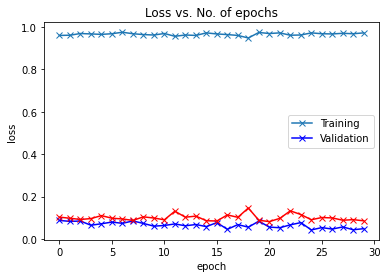

In [31]:
plot_accuracies(history)
plot_losses(history)

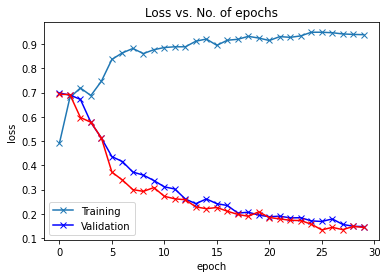

In [32]:
plot_accuracies(historyRMS)
plot_losses(historyRMS)

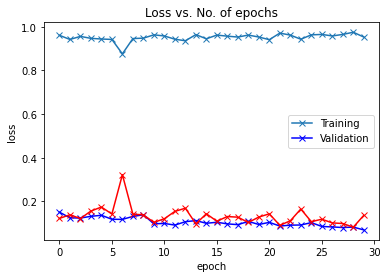

In [33]:
plot_accuracies(historyAdamW)
plot_losses(historyAdamW)

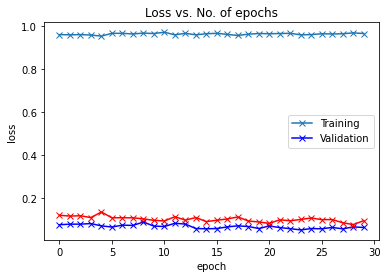

In [34]:
plot_accuracies(historyAdad)
plot_losses(historyAdad)

In [35]:
plot_accuracies(softhistory)
plot_losses(softhistory)

NameError: name 'softhistory' is not defined

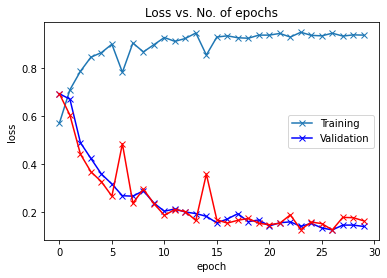

In [37]:
plot_accuracies(tanhistory)
plot_losses(tanhistory)